In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 200
LARGE_VAL = 10000000
ITER_THRESH = 5

In [2]:
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    news = fetch_20newsgroups(subset='all')
    all_data = np.array(news.data)
    all_targets = np.array(news.target)
    class_names = news.target_names

    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
    
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = TfidfVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    magnitudes1 = np.linalg.norm(view1_data, axis=1)
    magnitudes2 = np.linalg.norm(view2_data, axis=1)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((-1,1))
    magnitudes2 = magnitudes2.reshape((-1,1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels

In [3]:
v1_data, v2_data, labels = get_data()

In [ ]:
# 

In [4]:
#Function to initialize partitions
def initialize_partitions(data, c_centers):
    cosine_sims = np.matmul(data, np.transpose(c_centers))
    new_partitions = np.argmax(cosine_sims,axis = 1).flatten()
    return new_partitions

#A function to compute the value of the objective function
def compute_objective(data, c_centers, partitions):

    o_funct = 0
    for clust in range(c_centers.shape[0]):
        vecs = data[(partitions == clust)]
        dot_products = np.matmul(vecs, c_centers[clust].transpose())
        clust_sum = np.sum(1 - dot_products)
        o_funct += clust_sum
    return o_funct


#A function to run through a single iteration of maximization and expectation
#(in that order)
def iterate_clusters(data, partitions, k):

    #Recompute cluster centers
    new_centers = list()
    for clust in range(k):
        #print(np.sum(partitions == clust))
        summed_vec = np.sum(data[(partitions == clust)], axis = 0)
        magnitude = np.linalg.norm(summed_vec)
        if (magnitude == 0):
            magnitude = 1
        vec = summed_vec / magnitude 
        new_centers.append(vec)
    new_centers = np.vstack(new_centers)
        
    #Assign each sample point to a partition
    cosine_sims = np.matmul(data, np.transpose(new_centers))
    new_partitions = np.argmax(cosine_sims,axis = 1).flatten()

    return new_centers, new_partitions

In [5]:
#A function to consolidate the final clusters from the two views
def final_clusters(v_data, v_partitions, c_centers, k):

    v1_consensus = list()
    v2_consensus = list()
    for clust in range(k):
        part_indices = (v_partitions[0] == clust) * (v_partitions[1] == clust)
        #View 1
        summed_vec1 = np.sum(v_data[0][part_indices], axis = 0)
        magnitudes1 =  np.linalg.norm(summed_vec1)
        if(magnitudes1 == 0):
            magnitudes1 = 1
        vec1 = summed_vec1 / magnitudes1
        v1_consensus.append(vec1)

        #View 2
        summed_vec2 = np.sum(v_data[1][part_indices], axis = 0) 
        magnitudes2 =  np.linalg.norm(summed_vec2)
        if(magnitudes2 == 0):
            magnitudes2 = 1
        vec2 = summed_vec2 / magnitudes2
        v2_consensus.append(vec2)
        
    v1_consensus = np.vstack(v1_consensus)
    v2_consensus = np.vstack(v2_consensus)
        
    v1_arcos = np.arccos(np.matmul(v_data[0], np.transpose(v1_consensus)))
    v2_arcos = np.arccos(np.matmul(v_data[1], np.transpose(v2_consensus)))
    dist_metric = v1_arcos + v2_arcos
    new_partitions = np.argmin(dist_metric,axis = 1).flatten()
    return new_partitions

In [6]:
def compute_entropy(partitions, labels, k, num_classes):
    class_sizes = list()
    for ind in range(num_classes):
        class_sizes.append(np.sum(labels == ind))
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / class_sizes[cl]
            ent = 0
            if(prop != 0):
                ent = - prop * np.log(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

def compute_entropy2(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [7]:
#The main kmeans clustering algorithm
def spherical_kmeans(v_data, labels, k = 5):

    #Initialize cluster centers, partitions, and loop params
    
    c_centers2 = np.random.random((k, v_data[1].shape[1]))
    c_centers2 /= np.linalg.norm(c_centers2, axis=1).reshape((-1, 1))
    c_centers = [None, c_centers2]
    
    partitions2 = initialize_partitions(v_data[1], c_centers2)
    v_partitions = [None, partitions2]
    objective = [LARGE_VAL, LARGE_VAL]
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        c_centers[view], v_partitions[view] = iterate_clusters(v_data[view], v_partitions[(view + 1) % 2], k)
        o_funct = compute_objective(v_data[view], c_centers[view], v_partitions[view])
        iter_stall += 1
        #Recompute objective function
        if(o_funct < objective[view]):
            objective[view] = o_funct
            iter_stall = 0

        #Obtain evaluation metrics
        f_clusters = final_clusters(v_data, v_partitions, c_centers, k)
        entropy = compute_entropy2(f_clusters, labels, k, 5)

    return entropy

def getEntropies(v1_data, v2_data, labels):
    
    entropies = list()
    for num in range(1,11):
        ent = spherical_kmeans([v1_data, v2_data], labels, num)
        print(ent)
        entropies.append(ent)
    return entropies

In [14]:
#Do spherical kmeans and get entropy values for each k
num_trials = 5
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)

2.321928094887362
1.6680624324968463
1.0454671910182212
1.177131457021008
0.25537813938169435
0.28638297484820757
0.42741460277100307
0.7819065444243715
0.531209096102086
0.5867408850374712
2.321928094887362
1.5883740382828901
1.0542612062433387
0.6062993096304612
0.2576247238354347
0.3092482265521217
0.7670403628160514
0.39745337885203
0.5798198421960152
0.5848863746991247
2.321928094887362
1.7803954471179797
1.0496654211517558
0.5720661796736225
0.24016298591766205
0.29830025238779406
0.8931152629342474
0.8847609052535577
0.8510669108310301
0.6190041268773814
2.321928094887362
1.627659147816678
1.174231159598976
0.6213254108935253
0.2121451955570673
0.23337645363577303
0.3154345667109694
0.7641401730509216
0.5513516951295834
0.5796604873384068
2.321928094887362
1.6784492128946304
1.2255135903699945
0.6254006359534869
0.7636950339826809
0.3375576238330843
0.4483639825131368
0.5985934111991764
0.635821942102986
0.7919433216284996


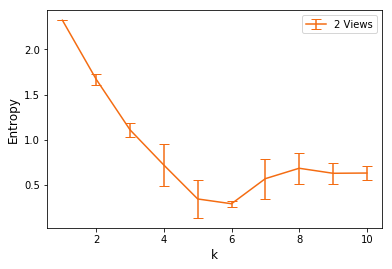

In [16]:
import matplotlib.pyplot as plt

mult_entropies = np.array(mult_entropies)
ave_m_entropies = np.mean(mult_entropies, axis=0)
std_m_entropies = np.std(mult_entropies, axis=0)
x_values = list(range(1, 11))
plt.errorbar(x_values, ave_m_entropies, std_m_entropies, capsize=5, color = '#F46C12')
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.rc('axes', labelsize=12)
plt.show()